# 2-layer GP

Recall from simple GP we have 
$$
y^* \sim N\left(B^T K^{-1} y , C(x^*,x^*) - B^T K^{-1} B    \right)
$$
where 
$$
B = C(x,x^*), K = C(x,x)
$$
with $x$ as known points, $x^*$ as unknown points. 


## Definition & notations

With two levels, we start from the top level (lowest resolution). In addition to known points $x$  and  unknown points $x^*$, we also have knots $x^\dagger$. We label them for as $x_i$ for $i$-th layer ($i$ starting from 0). At the parent level (0th-level), 
$$
B_{[0,0]} =  B_0 = C(x_0^\dagger, x_0^*), \\
B_{[0,0]} = K_0 = C(x_0^\dagger, x_0^\dagger). 
$$

At the 1st level, which is the lowest level in 2-layer GP, meaning we directly perform GP at this level's partition; all known points as knots $x_1=x_1^\dagger$: 
$$
B_{[1,1]} = C(x_1^\dagger, x_1^*) = C(x_1,x_1^*), \\
K_1 = C(x_1^\dagger,x_1^\dagger) = C(x_1,x_1).
$$
In addition, we need to connect this layer with the upper layer. We use the covariance function between child-level all location $x_1^*$ and parent-level all knots $x_0^\dagger$:  
$$
B_{[1,0]} = C (x_0^\dagger, x_1^*). 
$$


## Adding information within and across layers
We follow PyMRA exactly to project the 1st-layer observations $y_1$ to a new space ($H$ is m$\times$n-shaped from an eye matrix for alignment purposes, 1/R is a factor being 1e4):  
$$
y_{[1,0]}^\omega = B_{[1,0]}^T \cdot H^T (1/R) y_1,  \\
y_{[1,1]}^\omega = B_{[1,1]}^T \cdot H^T (1/R) y_1. 
$$
From the covariance matrix $B$, we know that $y_{[1,0]}$ connects information from parent-level other partitions' means, and $y_{[1,1]}$ connects information from child-level observations within a partition. Similarly, we project the 1st-layer covariance:
$$
B'_{[0,0]} = B_{[1,0]}^T H' B_{[1,0]}, \\
B'_{[0,1]} = B_{[1,0]}^T H' B_{[1,1]}, \\
B'_{[1,0]} = B_{[1,1]}^T H' B_{[1,0]}, \\
B'_{[1,1]} = B_{[1,1]}^T H' B_{[1,1]}.
$$
where $H' = (1/R) H^T H$ is generated from eye matrix for alignment purposes (to obtain valid observations). 

We can get the inverse of K at the child level (only information within the partition):
$$
{K_{1}'}^{-1} = (K_1 + B'_{[1,1]})^{-1}. 
$$
Then, we can get the mean estimates that cannot be explained by parent-level other partitions, i.e., only explained by this partition. In formula: observations = information (covariance within this partition's observations) + information (covariance between this partition's observation x parent-level other partitions) + information (this partition's mean). $y_{[1,0^s]}^\omega$ denotes connection with its own knot; $y_{[1,0]}^\omega$ dnotes connection with all knots from upper levels)
$$
y_{[1,0^s]}^\omega = y_{[1,0]}^\omega - B'_{[0,0]} \cdot {K_{1}'}^{-1} \cdot y_{[1,0]}^\omega 
$$

Covariance cannot be explained by the covariance with other partitions. 
$$
B'_{[0,0]} = B'_{[0,0]} - B'_{[0,1]} {K_{1}'}^{-1} B'_{[1,0]},
$$
$$ B'_{[0,1]} = B'_{[0,1]} - B'_{[0,1]} {K_{1}'}^{-1} B'_{[1,1]}. $$

## Posterior, starting from child-level. No cross-level information yet
$$
y^*_1 = B_{[1,1]} \cdot {K_{1}'}^{-1} \cdot y_{[1,1]}^\omega
$$ 



## Posterior, for top level (parent)
$$
{K_{0}'}^{-1} = (K_0 + A_{[0,0]})^{-1}
$$

To obtain the mean estimates, we start from the top level (parent). For all partitions, we sum their $y_{[1,0^s]}^\omega$, which is the values that can be explained from parent-level other partitions + self. 
$$
Y_{[1,0^s]} = \sum y_{[1,0^s]}^\omega
$$

Similarly, we sum the residuals in covariance, and assume they can be explained by the covariance of the parent-level's knots; we get its inverse that serves as the parent-level K: 
$$
\mathcal{B'}_{[0,0]}^{-1} =  (K_0 + \sum B'_{[0,0]})^{-1}
$$

The mean estimates explainable by parent-level information
$$
y^*_0 = \mathbb{B} \cdot \mathcal{B'}_{[0,0]}^{-1} \cdot Y_{[1,0^s]}
$$
where $\mathbb{B}$ is an empty matrix with a shape of $(n, m_0)$, with $n$ the total number of predicted observations and $m_0$ the number of knots at the top level. Then, at each level, for each partition, add their contributions to the mean estimates (only 1st-layer in our case because this is 2-layer GP):
$$
y^* = y^*_0 + y^*_1
$$



## Import packages

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform, pdist, cdist
import scipy.linalg as lng
from numpy.linalg import slogdet
from sklearn.metrics import r2_score, mean_squared_error
import scipy
import time
import scipy.optimize as opt
import logging
import numpy_indexed as npi

In [ ]:
#%% Additional setting for Google Cloud
!git clone https://github.com/sjliu68/pyMRAsampleData.git

## Distance function

In [2]:
#%% Distance Function
def dist(locs, locs2=np.array([]), circular=False):
    locs = locs if np.ndim(locs)==2 else np.reshape(locs, [len(locs), 1])
    if circular:
        if len(locs2):
            xv, yv = np.meshgrid(locs, locs2)
        else:
            xv, yv = np.meshgrid(locs, locs)
        m = np.minimum(xv, yv)
        M = np.maximum(xv, yv)
        dist = np.matrix(np.minimum(M - m, m + 1-M).T)
    else:
        if len(locs2):
            dist = np.matrix(cdist(locs, locs2))
            # dist = cdist(locs, locs2)
        else:
            dist = np.matrix(squareform(pdist(locs)))
    return dist

def ExpCovFun(locs, locs2=np.array([]), l=1, circular=False):
    D = dist(locs, locs2, circular)
    covMat = np.exp(-D/l)
    return(covMat)

def GetD(locs, locs2=np.array([]), l=1, circular=False):
    D = dist(locs, locs2, circular)
    # covMat = np.exp(-D/l)
    return(D)

## Load dataset

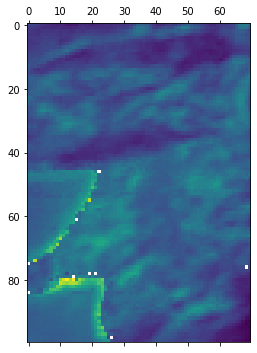

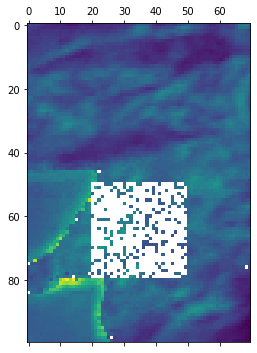

In [3]:
#%%
#%% load dataset, can ignore this part
x1 = np.load('pyMRAsampleData/xlon2019.npy')
x2 = np.load('pyMRAsampleData/xlat2019.npy')
mean = np.load('pyMRAsampleData/mean2019.npy')    
mean -= 97
mean /= 10

imx1,imx2,imy1,imy2 = 670,770,190,260

data = mean[imx1:imx2,imy1:imy2]
data2 = copy.deepcopy(mean[imx1:imx2,imy1:imy2])
plt.matshow(data)
plt.show()


x1 = x1[imx1:imx2,imy1:imy2]
x2 = x2[imx1:imx2,imy1:imy2]
x1 -= x1.min()
x2 -= x2.min()
x1 /= x1.max()
x2 /= x2.max()


### make random train/test
np.random.seed(42)
_x = 50
_y = 20
n = 30
data[_x:_x+n,_y:_y+n] = np.nan
for i in range(n):
    for j in range(n):
        if np.random.rand()<0.2:
            data[_x+i,_y+j] = data2[_x+i,_y+j]

plt.matshow(data)
plt.show()

#%
idx = np.isnan(data)
train_y = data[~idx]
train_x1 = x1[~idx]
train_x2 = x2[~idx]


test_x1 = x1[idx]
test_x2 = x2[idx]
test_y = data2[idx]
test_X = np.asarray([test_x1,test_x2]).T
train_X = np.asarray([train_x1,train_x2]).T

idx2 = np.isnan(test_y)
test_y2 = test_y[~idx2]

### overwrite here, make all data including nan
train_y = data.reshape(-1,1)
idx = np.arange(train_y.shape[0])
train_X = np.asarray([x1.reshape(-1),x2.reshape(-1)]).T

## Test code to see if the order of pixels unchanged after reshape
2-dimensional <-> 1-dimensional

In [4]:
#%%
# not related to main code, to ensure that the order of pixels are correct
# check the order after reshape, exactly the order
# '''

imindex = np.zeros(data.shape).astype(int)
imindex3 = np.zeros(data.shape).astype(int)
count = 0
for i in range(imindex.shape[0]):
    for j in range(imindex.shape[1]):
        imindex[i,j] = count
        count += 1
        imindex3[i,j] = i*imindex.shape[1]+j

imindex2 = imindex.reshape(-1)
imindex4 = imindex3.reshape(-1)

## Generate parent-level knots
```
(100,70), the image (1st-layer)
(10,7), 1-to-100 for parent-level (0th-layer)
```


In [5]:
#%%
# This is the structure to store data (simulating 2-layer data)
# making two-layer data from the 100*70 dataset


'''
-> 100*70
-> 10*7
-> 5*4? with overlapping partition (next time)

last layer: 100*70
first layer: 10*7

ratio: 10*10->1
'''

trees = {}

im1 = {} # 1st layer, 10*7
idx1 = 0
for i in range(10):
    for j in range(7):
        value = np.nanmean(data[i*10:(i+1)*10,j*10:(j+1)*10])
        child = {}
        child['value'] = value
        child['loc'] = np.array([np.mean(x1[i*10:(i+1)*10,j*10:(j+1)*10]),np.mean(x2[i*10:(i+1)*10,j*10:(j+1)*10])])
        child['parentpixid'] = ((i*10)+(i+1)*10)//2*70 + (j*10+(j+1)*10)*10//2

        childlist = []
        for i2 in range(i*10,(i+1)*10):
            for j2 in range(j*10,(j+1)*10):
                childlist.append([i2,j2])
        childlist = np.array(childlist)
        trees['a'+str(idx1)] = childlist
        
        
        child['childid'] = childlist
        child['childvalue'] = data[child['childid'][:,0],child['childid'][:,1]]
        child['childpixelid'] = imindex[child['childid'][:,0],child['childid'][:,1]]
        
        child['childloc'] = np.array([x1[child['childid'][:,0],child['childid'][:,1]], 
                             x2[child['childid'][:,0],child['childid'][:,1]]]).T
        
        im1['a'+str(idx1)] = child
        idx1 += 1

## Get prior for the parent level (0th)

Structure discussion: should use the object-oriented coding in PyMRA
```
Now: params['K']
PyMRA: params.K
```

In [6]:
#%% top-layer, low-resolution, data + prior
pas = {}
pas['a'] = {}

phi = 0.5
sigma = 1
locs = train_X
N = locs.shape[0]

knots = []
ys = []
for each in im1:
    knots.append(im1[each]['loc'])
    ys.append(im1[each]['value'])
knots = np.array(knots)
ys = np.array(ys)

B = sigma**2 * np.exp(-phi * GetD(locs,knots))
K = sigma**2 * np.exp(-phi * GetD(knots,knots))
Kinv = np.linalg.inv(K)

pas['a']['B'] = B
pas['a']['K'] = K
pas['a']['Kinv'] = Kinv
pas['a']['knots'] = knots
pas['a']['ys'] = ys

## Child-level, prior + posterior

In [7]:
#%% lowest-layer, high-resolution, data+prior
nnans = []
# each = 'a45'
for each in im1.keys():
    
    
    res = 1
    
    R = 0.00001
    pas[each] = {}
    note1 = im1[each]
    
    
    obs = note1['childvalue'].reshape(-1,1)

    idx1 = ~np.isnan(note1['childvalue']) # True=valid data
    nnans.append(np.sum(idx1))
    
    knots1 = note1['childloc'][idx1]
    locs1 = note1['childloc']
    
    n1 = note1['childvalue'].shape[0]
    n2 = idx1.shape[0]
    
    obsInds = np.array(np.isfinite(obs)).ravel()
    H = np.matrix(np.eye(n1))[obsInds,:]
    
    B1 = sigma**2 * np.exp(-phi * GetD(locs1,knots1))
    K1 = sigma**2 * np.exp(-phi * GetD(knots1,knots1))
    B0 = sigma**2 * np.exp(-phi * GetD(locs1,pas['a']['knots'])) # upper layer information
    covCh = sigma**2 * np.exp(-phi * GetD(locs1,locs1)) - B0 * Kinv * B0.T
    
    
    # tmp variables
    HRinvH = (1/R)*H.T*H
    HRinvObs = H.T*(1/R)*obs[obsInds]
    
    B_lk = [B0, B1] # two layers
    BTil = B_lk
    
    omg = [ B_lk[0].T * HRinvObs, B_lk[1].T * HRinvObs ]
    
    A = []
    A.append( [ B_lk[0].T * HRinvH * B_lk[0], B_lk[0].T * HRinvH * B_lk[1] ] )
    A.append( [ B_lk[1].T * HRinvH * B_lk[0], B_lk[1].T * HRinvH * B_lk[1] ] )
    
    
    kTil = np.matrix(lng.inv(K1 + A[-1][-1]))
    kTilInv = lng.inv(kTil)
    

    if True:
        # calculate A-tilde and omega-tilde
        ATil = []
        omgTil = []
        ATil.append([])
        ATil[0].append( A[0][0] - A[0][res]*kTil*A[res][0]  )
        ATil[0].append( A[0][1] - A[0][res]*kTil*A[res][1]  )
        
        omgTil = []
        omgTil.append( omg[0] - A[0][res]*kTil*omg[res]    )
        
    
    
    # mean + variance
    mean = BTil[res] * kTil * omg[res]
    
    # keep variables
    pas[each]['B1'] = B1
    pas[each]['K'] = K1
    pas[each]['B0'] = B0
    pas[each]['covCh'] = covCh
    pas[each]['ys'] = note1['childvalue'][idx1]
    pas[each]['omgTil'] = omgTil
    pas[each]['ATil'] = ATil
    pas[each]['chPixIndex'] = note1['childpixelid']
    pas[each]['mean'] = mean

## Posterior, parent-level + adding contributions from child-level

In [8]:
#%% Get posterior
# At the parent level
res = 0
alist = []
for i in range(70):
    alist.append('a'+str(i))

subList = []
for each in alist:
    note1 = pas[each]
    subList.append(note1['omgTil'][0])
omg = []
omg.append( sum(subList) )   # sum all contributions from children, intercorrelation with children


# At the child level
A = []
A.append([]) # resolution
subList = []
for each in alist:
    note1 = pas[each]
    subList.append(note1['ATil'][0][0])
A[0].append(sum(subList))
    
kTil = np.matrix(lng.inv(pas['a']['K'] + A[res][res]))
kTilInv = lng.inv(kTil)

BTil = []
N = 7000 # all locations
n = 70 # knots at the first level

BTil.append( np.matrix(np.zeros((N, n))) )
mean = BTil[res] * kTil * omg[res]
    
    

for each in alist:
    chInds = pas[each]['chPixIndex']
    mean[chInds,:] += pas[each]['mean']

## Test Code

| Method           |        R^2 | 
|:-----------------|-----------:|
| Native GP        |      0.793 | 
| This 2-layer GP  |      0.717 |  
| PyMRA            |      0.737 |  


```
knots are different in PyMRA
```

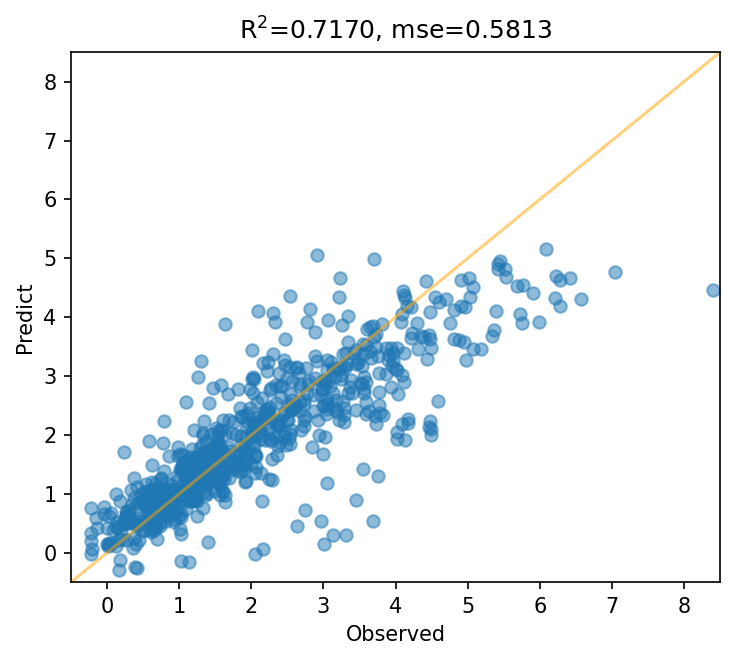

In [9]:
#%% test
'''
Native GP: R^2=0.793

[1] 2-layer: R^2=0.717
[2] PyMRA similar to 2-layer, R^2=0.737


Knots in [1] and [2] are different!!!
Similar framework, totally different assumptions

in PyMRA, knots are the k-mean centers (similar to support vectors)

'''

ypre = mean
idx = np.where(np.isnan(train_y)) # test only on unknown locations
y2p = ypre[idx]
y2p = np.squeeze(np.asarray(y2p))
y2g = data2.reshape(-1,1)[idx]

# further cleanup. data originally contain NaN
idx2 = np.isnan(y2g)
y2g2 = y2g[~idx2]
y2p2 = y2p[~idx2]


# plot data
r2 = r2_score(y2g2, y2p2)
mse = mean_squared_error(y2g2, y2p2)

fig = plt.figure(figsize=(5,4.5),dpi=150)
plt.plot(np.arange(-5,10),np.arange(-5,10),c='orange',alpha=0.5)
plt.scatter(y2g,y2p,alpha=0.5)
plt.xlabel('Observed')
plt.ylabel('Predict')
plt.title('R$^2$='+f'{r2:.4f}'+', mse='+f'{mse:.4f}')
plt.xlim(-0.5,8.5)
plt.ylim(-0.5,8.5)
plt.tight_layout()
plt.show()